It's interesting to note that in deep learning, the evolution of architecture and techniques is very rapid, but that certain aspects can remain present for years in bits of code, without really knowing if they are totally necessary. Most of the time, we take for granted that these were optimized and this should not be taken care of.

One such aspect is *input normalization*, which is used as input to most convolutional neural networks (CNNs) used to process visual images. This is all the more true as we often use in the community networks that are pre-trained for images normalized to given values, like VGG or ResNET. When you ask Github's copilot, it says that 

>    Image normalization in convolutional neural networks (CNNs) has several beneficial effects:
>    1- Improved convergence: Normalization helps to stabilize and speed up the learning process by ensuring that pixel values are in a similar range, thus facilitating optimization.
>    2- Reduced sensitivity to scale variations: Normalizing images reduces the model's sensitivity to scale variations in pixel values, which can improve model robustness.
>    3- Prevention of neuron saturation: Unnormalized pixel values can lead to neuron saturation, which slows down learning. Normalization helps prevent this problem.
>    4- Improved performance: In general, image normalization can lead to better model performance in terms of accuracy and generalization.


**I'm interested here in whether these networks remain effective when we change the input normalization.** Indeed, as the weights of the first convolutional layer are learned, and as convolution kernels can be multiplied by arbitrary values thanks to the bias in the convolutions, normalizing to a certain value makes no sense, and simply normalizing does. This is even more evident when that values are given with 3 digits of precision! I propose here to show quantitatively that this is the case, first for a *historical* network [LeNet](https://en.wikipedia.org/wiki/LeNet) applied to the MNIST challenge, and then for [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) applied to ImageNet.


<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
from __future__ import division, print_function
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
#%config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)
from IPython.display import display, HTML
def show_video(filename): 
    return HTML(data='<video src="{}" loop autoplay width="600" height="600"></video>'.format(filename))
%load_ext autoreload
%autoreload 2

In [2]:
%mkdir -p data

# The MNIST challenge and the *French Touche* 

First, let's explore the *LeNet* network  (Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition" (PDF). Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791. S2CID 14542261), whose objective is to categorize images of written digits, one of the first great successes of Multilayer neural networks. For this one, we're going to use the classic implementation, as proposed in the PyTorch library example series. 

The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures that are applied to the database. The output accuracy value corresponds to the percentage of letters that are correctly classified.

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function, which we'll be manipulating in the course of this book.

In [ ]:
# adapted from https://raw.githubusercontent.com/pytorch/examples/refs/heads/main/mnist/main.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

epochs = 25

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


def main(mean, std, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
        ])
    dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)

    dataset2 = datasets.MNIST('data', train=False,
                       transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)

    model.conv1.bias.data -= mean
    model.conv1.weight.data /= std

    
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)

    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'max')
    for epoch in range(1, epochs+1):
        train(model, device, train_loader, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        accuracy = test(model, device, test_loader, verbose=verbose)
        scheduler.step(accuracy)

    return accuracy



You can notice that I made one change by using the `ReduceLROnPlateau` scheduler instead of `StepLR`. In practice, this only changed the values I could test - run the notebook with enough epochs and the other scheduler to make your own opinion.

Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code with 3 digits precision (!) :

In [4]:
accuracy = main(mean=0.1307, std=0.3081, verbose=True)
print(f'{accuracy=:.4f}')


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320047
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.385446
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.216259
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.270252
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.066053
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.147345
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.160141
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.142902
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.187834
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.123036

Test set: Average loss: 0.0472, Accuracy: 9828/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.050218
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.228272
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.177290
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.205904
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.024260
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.085000
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.075375
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.011151
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.138641
T

This was first introduced in that code on [Jan 17, 2017](https://github.com/pytorch/examples/commit/32c7386aef93737926069ee284d827f8e954e086) and these exact values have not changed since (up to  the 3rd digit).

One advantage of our code is that we can now manipulate these two values, to see if starting from the same code we obtain an accuracy value that is different.



In [5]:
accuracy = main(mean=0., std=1.)
print(f'{accuracy=:.4f}')


accuracy=0.9926


The result seems similar, but it's not enough to demonstrate that the mean and standard deviation have no effect on learning.

## using optuna

I'm now going to push the boat out further, using a library that allows me to test several values and thus optimize the parameters. If the mean and deviation are so important, we'll converge on a fixed set of values, whereas if they're less important, the values can be quite scattered. In particular, this will allow us to choose an arbitrary value, such as a mean of 0 and a standard deviation of 1, better known as *normal* normalization.

In [24]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
path_save_optuna =  'optuna-MNIST.sqlite3'

In [ ]:
# %rm {path_save_optuna}

rm: optuna-MNIST.sqlite3: No such file or directory


In [ ]:
def objective(trial):
    mean = trial.suggest_float('mean', -3, 3, log=False)
    std = trial.suggest_float('std', 0.1, 2, log=True)
    accuracy = main(mean=mean, std=std)
    return accuracy


study = optuna.create_study(direction='maximize', load_if_exists=True, 
                                storage=f"sqlite:///{path_save_optuna}", study_name='MNIST')
if not(os.path.isfile(path_save_optuna)):
    study.optimize(objective, n_trials=200, n_jobs=1, show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print(50*'=')


-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean': -0.4154915922090767, 'std': 1.4084939421254434}
Best value:  0.993
Best Trial:  FrozenTrial(number=3, state=1, values=[0.993], datetime_start=datetime.datetime(2024, 12, 12, 0, 46, 6, 248425), datetime_complete=datetime.datetime(2024, 12, 12, 0, 48, 3, 531044), params={'mean': -0.4154915922090767, 'std': 1.4084939421254434}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'mean': FloatDistribution(high=3.0, log=False, low=-3.0, step=None), 'std': FloatDistribution(high=10.0, log=True, low=0.1, step=None)}, trial_id=4, value=None)


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_60343/4135129822.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
[W 2024-12-13 13:02:09,814] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


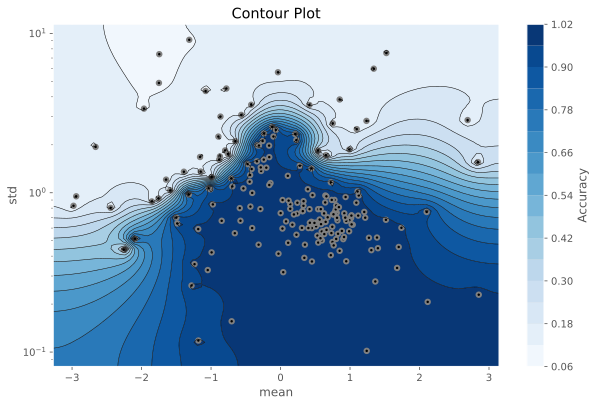

In [ ]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
fig = plt.gcf()
fig.set_size_inches(figsize[0], figsize[1])

# The ImageNet challenge and *residual networks* 

Second, let's tackle a real world problem: image classification with 1 million images and 1000 labels. For this we will use the well-known Resnet model defined in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) as it givves a nice balance between simplicity and performance.

The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures that are applied to the database. The output accuracy value corresponds to the percentage of images that are correctly classified. To simplify things, we will use pretrained weights and the retraining protocol which were used in [Jean-Nicolas Jérémie, Laurent U Perrinet (2023). Ultra-Fast Image Categorization in biology and in neural models.](https://laurentperrinet.github.io/publication/jeremie-23-ultra-fast-cat/) and available in the following code [UltraFastCat.ipynb](https://nbviewer.org/github/JNJER/2022-03_UltraFastCat/blob/main/UltraFastCat.ipynb)

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function, which we'll be manipulating in the course of this book. Since we have colored images, that is, 3 channels, it means we manipulate 6 variables.

https://pytorch.org/hub/pytorch_vision_resnet/

In [10]:
import torch
from torchvision.models import ResNet18_Weights

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# model.eval()
model

Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# model.conv1.weight.data 

In [12]:
epochs = 1

def train(model, device, train_loader, criterion, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    if verbose:
        print('\nTest set: Av Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

def main(mean, std, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    # preprocess = transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.CenterCrop(224),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # ])

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        transforms.Normalize((mean, mean, mean), (std, std, std))
        ])
    

    DATADIR = '/Volumes/data/2024_archives/2024_science/Deep_learning/data/Imagenet_full'
    DATADIR = '/Volumes/data/2024_archives/2024_science/Deep_learning/data/Imagenet_redux'
    train_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/train', transform=transform), **train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/val', transform=transform), **test_kwargs)

    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT)
    model = model.to(device)

    # model.conv1.bias.data -= mean
    model.conv1.weight.data /= std

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(1, epochs):
        train(model, device, train_loader, criterion, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        scheduler.step()

    accuracy = test(model, device, test_loader, verbose=verbose)
    return accuracy



In [13]:
accuracy = main(mean=0., std=1.)
print(f'{accuracy=:.4f}')


Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0


accuracy=0.4568


In [14]:
path_save_optuna =  'optuna-ResNet.sqlite3'

In [ ]:
# %rm {path_save_optuna}

rm: optuna-ResNet.sqlite3: No such file or directory


In [ ]:
def objective(trial):
    mean = trial.suggest_float('mean', -3, 3, log=False)
    std = trial.suggest_float('std', 0.1, 10, log=True)
    accuracy = main(mean=mean, std=std)
    return accuracy


study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name='MNIST')
if True: #not(os.path.isfile(path_save_optuna)):
    study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print(50*'=')


  0%|          | 0/200 [00:00<?, ?it/s]

Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_

[W 2024-12-13 11:07:59,932] Trial 112 failed with parameters: {'mean': 0.453309823244732, 'std': 0.47797585500732337} because of the following error: OSError(5, 'Input/output error').
Traceback (most recent call last):
  File "/Users/laurentperrinet/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_60343/716646907.py", line 4, in objective
    accuracy = main(mean=mean, std=std)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_60343/848214305.py", line 89, in main
    accuracy = test(model, device, test_loader, verbose=verbose)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_60343/848214305.py", line 23, in test
    for data, target in test_loader:
                        ^^^^^

OSError: [Errno 5] Input/output error

In [ ]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
fig = plt.gcf()
fig.set_size_inches(figsize[0], figsize[1])

## some book keeping for the notebook

In [ ]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,torch  -r -g -b